<font color='blue'> **a01b - Freyberg (1988) - Steady State** </font> <font color='red'> **Loading** </font> 

In [1]:
import numpy as np ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import pandas as pd
import flopy ; from flopy.plot import styles;  from pathlib import Path; import os 

In [2]:
sim_ws1 = Path("./a01a")   # sim_ws1    = Path("../bin/Flopy_data/mf6-freyberg")  
sim_ws2 = Path("./data/Freyberg")     ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; sim_name = "Freyberg"
sim_ws3 = Path("./a01b")              ; sim_ws2.mkdir(exist_ok=True)

<font color='blue'> **Run 01_FreybergOnline.ipynb first!** 

In [3]:
sim = flopy.mf6.MFSimulation.load(sim_ws = sim_ws1, verbosity_level=0, exe_name=exe_name)    ; gwf = sim.get_model(sim_name)  
modelgrid = gwf.modelgrid  #; modelgrid.set_coord_info(xoff=0,yoff=0,angrot=0,crs="+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
print(f"Grid shape: {modelgrid.shape}\n") 

Grid shape: (1, 40, 20)



In [4]:
sim.set_sim_path(sim_ws3)  ; sim.write_simulation()  ; sim.run_simulation(silent=True, report=False)

(True, [])

In [5]:
gwf = sim.get_model(sim_name) ; hds = gwf.output.head() ; head = hds.get_alldata()[0]   ; wel = gwf.get_package("WEL-1")
sat_thk = gwf.modelgrid.saturated_thickness(head, mask=[1e30])  ; thk = gwf.modelgrid.cell_thickness

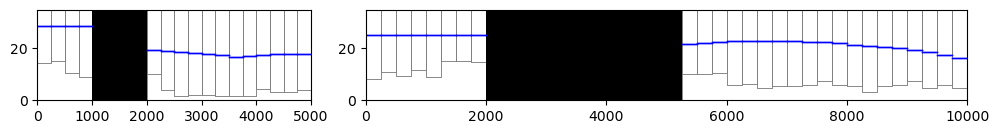

In [6]:
from flopy.utils.postprocessing import get_water_table ; wt = get_water_table(head)
irow, icol = gwf.modelgrid.intersect(1700, 6000)  
def beta_plot(ax):
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax2, line={"column": icol}) ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive()
    pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax1,line={"row": irow})     ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive()
    pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1, rowspan=1)  ;   
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=1)  ; beta_plot(ax1) ; beta_plot(ax2) 

In [9]:
fpath1 = os.path.join(sim_ws2,"bottom.txt")   ; bottom  = np.loadtxt(fpath1)  ; botm = modelgrid.botm
Hk = gwf.npf.k.get_data() ; print(Hk.shape)

(1, 40, 20)


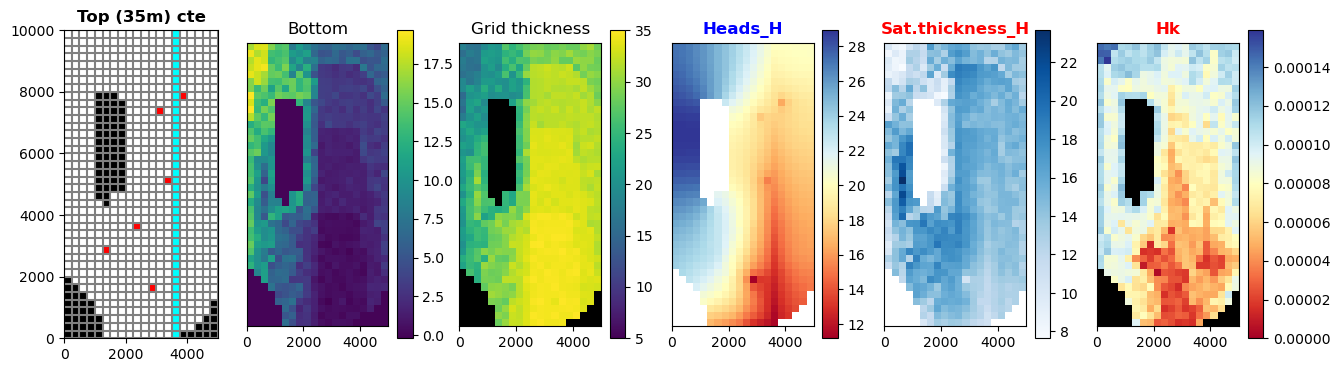

In [10]:
fig = plt.figure(figsize=(16, 4))                             
ax1 = fig.add_subplot(151) ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)                     ; mm.plot_grid()                    
mm.plot_ibound(); mm.plot_bc(package=wel)             ; mm.plot_bc("CHD" , color="white" );  mm.plot_bc("RIV" , color="cyan") ; ax1.set_title("Top (35m) cte", fontweight='bold')          
ax2 = fig.add_subplot(162) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array([bottom])               ; ax2.set_title("Bottom")                                                  ;ax2.yaxis.set_visible(False) ; plt.colorbar(pc) 
ax3 = fig.add_subplot(163) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array(thk,vmin=5,vmax=35)     ; ax3.set_title("Grid thickness" )   ; pm.plot_ibound()                    ;ax3.yaxis.set_visible(False) ; plt.colorbar(pc) 
ax4 = fig.add_subplot(164) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array(head, cmap='RdYlBu')    ; ax4.set_title("Heads_H", color = 'blue', fontweight='bold')              ;ax4.yaxis.set_visible(False) ; plt.colorbar(pc)
ax5 = fig.add_subplot(165) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array(sat_thk,cmap='Blues')  ; ax5.set_title("Sat.thickness_H", color = 'red', fontweight='bold')  ;ax5.yaxis.set_visible(False) ; plt.colorbar(pc)
ax6 = fig.add_subplot(166) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array(Hk,cmap='RdYlBu')  ; ax6.set_title("Hk", color = 'red', fontweight='bold')  ;ax6.yaxis.set_visible(False) ; plt.colorbar(pc)
pm.plot_ibound(); plt.show()

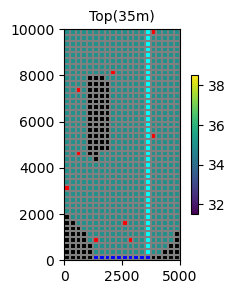

In [11]:
x = modelgrid.xoffset + np.random.rand(10)*4000 ; y=modelgrid.yoffset + np.random.rand(10) * 10000  ;q=np.random.rand(10) * -0.02 ; pdata = []
for ix, xc in enumerate(x):
    i, j = modelgrid.intersect(xc, y[ix], forgive=True)
    if not np.isnan(i) and not np.isnan(j):
        if modelgrid.idomain[0, i, j]:  pdata.append([(0, i, j), q[ix]])
gwf.remove_package("wel_0")  ; stress_period_data = {0: pdata}                              #   ; nouter=100  ;ninner=25 ;hclose=1e-9 ;rclose=1e-3
wel = flopy.mf6.modflow.ModflowGwfwel(gwf, stress_period_data=stress_period_data)           #   ; nouter=1000 ;ninner=25 ;hclose=1e-3 ;rclose=1e-1
fig = plt.figure(figsize=(3, 3))                             
ax1 = fig.add_subplot(111, aspect="equal")    ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)  
pc = mm.plot_array([modelgrid.top])           ; plt.colorbar(pc, shrink=.6) 
mm.plot_bc(package=wel)    ; mm.plot_bc("RIV" , color="cyan") ; mm.plot_ibound()
mm.plot_grid()             ; mm.plot_bc("CHD" , color="blue" )              ; ax1.set_title("Top(35m)", fontsize=10)
plt.show()

**Run again ...** <font color='red'> **True results only If convergence occurs** </font> 
<font color='blue'> **True results only If convergence occurs** </font> **True | False**

In [ ]:
nouter=1000 ;ninner=25 ;hclose=1e-3 ;rclose=1e-1
flopy.mf6.ModflowIms     (sim,linear_acceleration="BICGSTAB",outer_maximum=nouter,outer_dvclose=hclose * 10.0,inner_maximum=ninner,
                          inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
sim.set_sim_path(sim_ws2)  ; sim.write_simulation()  ; sim.run_simulation(silent=True, report=False)

(False, [])

In [ ]:
gwf = sim.get_model(sim_name) ; hds = gwf.output.head() ; head = hds.get_alldata()[0]   ; wel = gwf.get_package("WEL-1")
sat_thk = gwf.modelgrid.saturated_thickness(head, mask=[1e30])  ; thk = gwf.modelgrid.cell_thickness

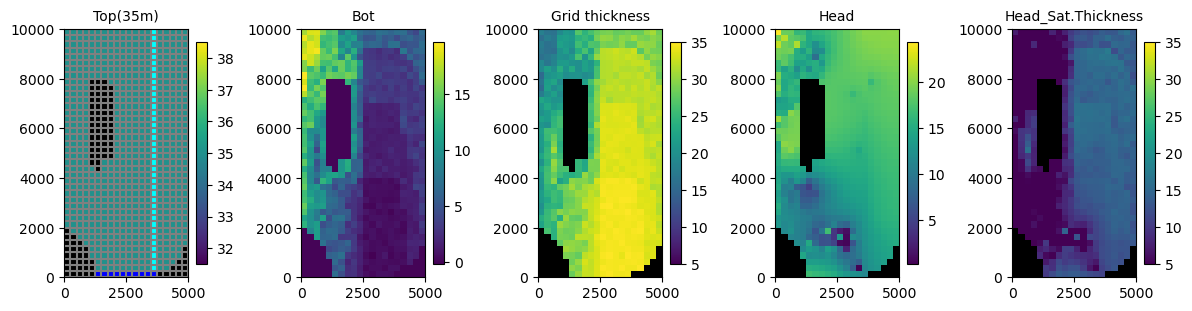

In [ ]:
fig = plt.figure(figsize=(12, 4))                             
ax1 = fig.add_subplot(151, aspect="equal")    ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)  
pc = mm.plot_array([modelgrid.top])           ; plt.colorbar(pc, shrink=.6) #mm.plot_bc(package=wel)    
mm.plot_bc("RIV" , color="cyan") ; mm.plot_ibound()
mm.plot_grid()             ; mm.plot_bc("CHD" , color="blue" )              ; ax1.set_title("Top(35m)", fontsize=10)

ax2 = fig.add_subplot(152, aspect="equal")    ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid)  
pc  = pm.plot_array([bottom])          ; plt.colorbar(pc,shrink=.6)  ; ax2.set_title("Bot", fontsize=10)
ax3 = fig.add_subplot(153, aspect="equal")    ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) 
pc  = pm.plot_array(thk, vmin=5, vmax=35)     ; plt.colorbar(pc, shrink=.6) ; ax3.set_title("Grid thickness", fontsize=10); pm.plot_ibound()
ax4 = fig.add_subplot(154, aspect="equal")    ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid)  
pc  = pm.plot_array(head)                     ; plt.colorbar(pc, shrink=.6) ; ax4.set_title("Head", fontsize=10); pm.plot_ibound()
ax5 = fig.add_subplot(155, aspect="equal")    ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) 
pc  = pm.plot_array(sat_thk, vmin=5, vmax=35) ; plt.colorbar(pc,shrink=.6)  ; ax5.set_title("Head_Sat.Thickness", fontsize=10) ; pm.plot_ibound()
plt.tight_layout(); plt.show()